# Learning dynamics evaluation

We evaluate the learning dynamics of ISC and MLP models here, starting by performing PCAs on both models.

## 1. ISC model PCA

In [17]:
import os
import warnings

import data
import pandas as pd
import torch
from scipy.stats import ttest_rel
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

from experimental_setups import isc_model, mlp_model

warnings.filterwarnings('ignore')

In [18]:
model_path = 'models'
num_models = 10
num_bootstrap_sims = 10000
num_training_epochs = 30
num_training_epochs_comparison = 10
train_model = False
train_comparison_model = False

num_objects = 350
num_tasks = 36
num_task_context_units = 16
num_context_independent_units = 64
num_context_dependent_units = 128
size_idx = 2541  # Index of the "is_small" feature
size_task_idx = 33  # Index of the size task

train_x,train_y,size_conditions,cat_conditions,random_cat_conditions,blocks = data.make_behavioral_experiment_training_data(distractor_strength=.975)

In [19]:
def calc_model_error(model,train_x,train_y,noise=0):
    errors = torch.abs(model(train_x,noise=noise)-train_y)[:,[2541,2542]].mean(axis=-1)
    return errors.cpu().detach().numpy()

In [20]:
# load ISC model
isc_models = isc_model.model.load_isc_models(num_models, train_model, num_training_epochs, model_path)

error_data = []
for model_idx in range(1):
    simulation_model = isc_model.model.ISCModel(device='mps',num_tasks=5,num_task_context_units=16,num_context_dependent_hidden_units=128)
    save_file = f'isc_model-{model_idx}-bhvsim.torch'
    if save_file in os.listdir('models'):
        simulation_model.load_state_dict(torch.load(os.path.join('models',save_file)))
    else:
        simulation_model.load_old_model_weights(isc_models[model_idx].state_dict(),use_old_size_starting_point = True)
        errors = calc_model_error(simulation_model,train_x,train_y)
        c=1
        while errors.mean() > 0.18:
            simulation_model.train(train_x,train_y,epochs=1)
            errors = calc_model_error(simulation_model,train_x,train_y)
            c+=1
        print(model_idx, errors.mean(),c)

In [21]:
# indices of stimuli used for behavioral simulation
big_animal_indices = [118,104,30,48,116]
small_animal_indices = [105,115,29,57,59]
animal_indices = big_animal_indices + small_animal_indices

big_instrument_indices = [248,252,261,263,257]
small_instrument_indices = [262,253,266,267,260]
instrument_indices = big_instrument_indices + small_instrument_indices

experiment_stimulus_indices = animal_indices+instrument_indices

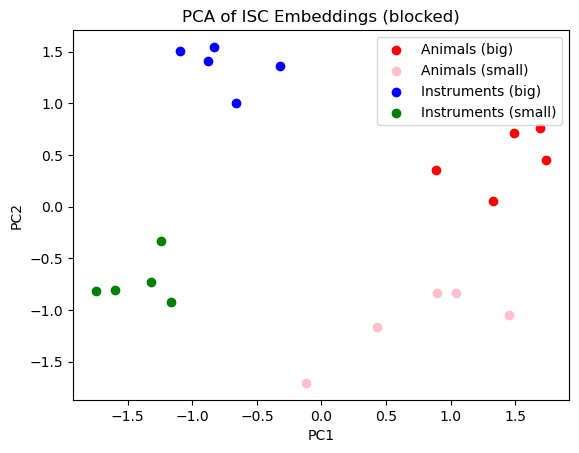

In [22]:
# context dependent reps for blocked setting
embeddings = simulation_model.get_context_dependent_reps(experiment_stimulus_indices)[1]
X = np.asarray(embeddings)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure()
plt.scatter(X_pca[:5, 0], X_pca[:5, 1], color='red', label='Animals (big)')
plt.scatter(X_pca[5:10, 0], X_pca[5:10, 1], color='pink', label='Animals (small)')

plt.scatter(X_pca[10:15, 0], X_pca[10:15, 1], color='blue', label='Instruments (big)')
plt.scatter(X_pca[15:, 0], X_pca[15:, 1], color='green', label='Instruments (small)')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of ISC Embeddings (blocked)")
plt.legend()
plt.savefig("images/pca_isc_blocked.png")
plt.show()

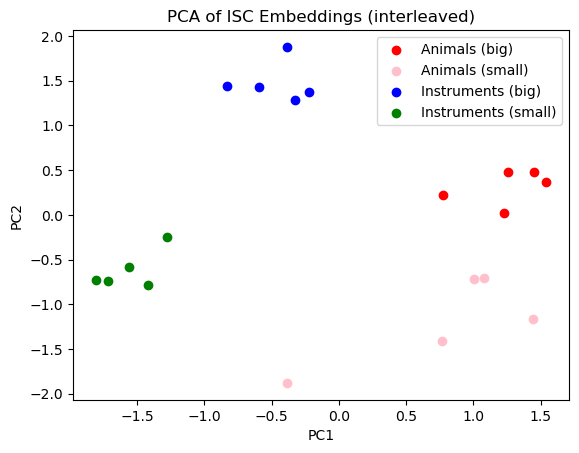

In [23]:
# context dependent reps for interleaved setting
embeddings = simulation_model.get_context_dependent_reps(experiment_stimulus_indices)[2]
X = np.asarray(embeddings)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure()
plt.scatter(X_pca[:5, 0], X_pca[:5, 1], color='red', label='Animals (big)')
plt.scatter(X_pca[5:10, 0], X_pca[5:10, 1], color='pink', label='Animals (small)')

plt.scatter(X_pca[10:15, 0], X_pca[10:15, 1], color='blue', label='Instruments (big)')
plt.scatter(X_pca[15:, 0], X_pca[15:, 1], color='green', label='Instruments (small)')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of ISC Embeddings (interleaved)")
plt.legend()
plt.savefig("images/pca_isc_interleaved.png")
plt.show()

## 2. MLP Model PCA

In [24]:
error_data = []
for model_idx in range(1):
    simulation_model = mlp_model.model.MLPModel(device='mps',num_tasks=5,num_context_dependent_hidden_units=128)

    save_file = f'mlp_model-{model_idx}-bhvsim.torch'
    if save_file in os.listdir('models'):
        simulation_model.load_state_dict(torch.load(os.path.join('models',save_file)))
    else:
        # model training
        errors = calc_model_error(simulation_model,train_x,train_y)
        c=1
        while errors.mean() > 0.18:
            simulation_model.train(train_x,train_y,epochs=1)
            errors = calc_model_error(simulation_model,train_x,train_y)
            c+=1
        print(model_idx, errors.mean(),c)

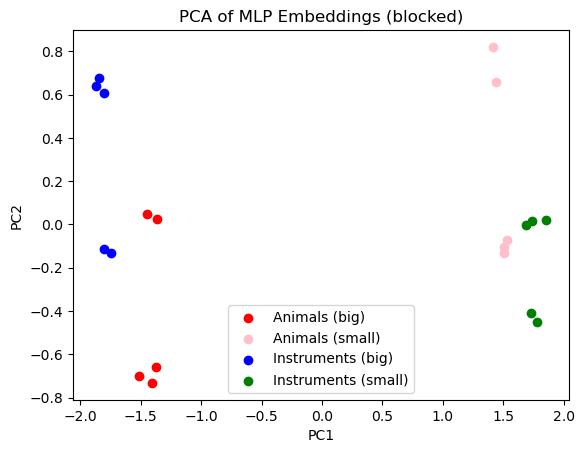

In [25]:
# context dependent reps for blocked setting
embeddings = simulation_model.get_context_dependent_reps(experiment_stimulus_indices)[1]
X = np.asarray(embeddings)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure()
plt.scatter(X_pca[:5, 0], X_pca[:5, 1], color='red', label='Animals (big)')
plt.scatter(X_pca[5:10, 0], X_pca[5:10, 1], color='pink', label='Animals (small)')

plt.scatter(X_pca[10:15, 0], X_pca[10:15, 1], color='blue', label='Instruments (big)')
plt.scatter(X_pca[15:, 0], X_pca[15:, 1], color='green', label='Instruments (small)')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of MLP Embeddings (blocked)")
plt.legend()
plt.savefig("images/pca_mlp_blocked.png")
plt.show()

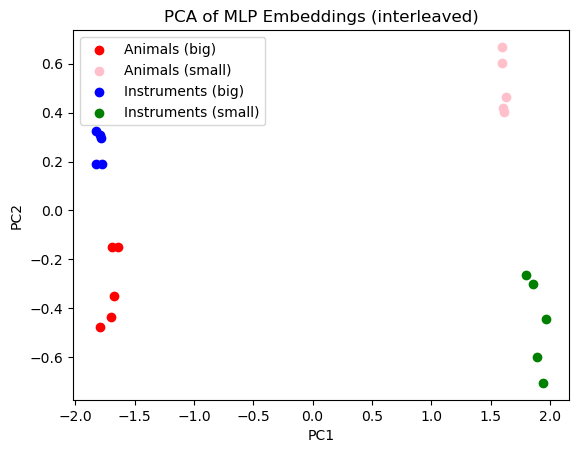

In [26]:
# context dependent reps for interleaved setting
embeddings = simulation_model.get_context_dependent_reps(experiment_stimulus_indices)[2]
X = np.asarray(embeddings)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure()
plt.scatter(X_pca[:5, 0], X_pca[:5, 1], color='red', label='Animals (big)')
plt.scatter(X_pca[5:10, 0], X_pca[5:10, 1], color='pink', label='Animals (small)')

plt.scatter(X_pca[10:15, 0], X_pca[10:15, 1], color='blue', label='Instruments (big)')
plt.scatter(X_pca[15:, 0], X_pca[15:, 1], color='green', label='Instruments (small)')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of MLP Embeddings (interleaved)")
plt.legend()
plt.savefig("images/pca_mlp_interleaved.png")
plt.show()

## 3. Learning curves

0 0.17895511 22


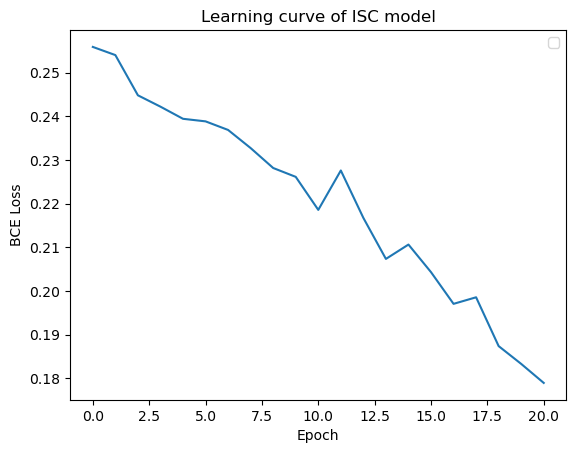

In [27]:
# train ISC model
error_data_isc = []
simulation_model = isc_model.model.ISCModel(device='mps',num_tasks=5,num_task_context_units=16,num_context_dependent_hidden_units=128)
simulation_model.load_old_model_weights(isc_models[model_idx].state_dict(),use_old_size_starting_point = True)
errors = calc_model_error(simulation_model,train_x,train_y)
c=1
while errors.mean() > 0.18:
    simulation_model.train(train_x,train_y,epochs=1)
    errors = calc_model_error(simulation_model,train_x,train_y)
    error_data_isc += [errors.mean()]
    c+=1
print(model_idx, errors.mean(),c)

plt.plot(range(len(error_data_isc)), error_data_isc)

plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Learning curve of ISC model")
plt.legend()
plt.savefig("images/learning_curve_isc.png")
plt.show()

0 0.17764568 78


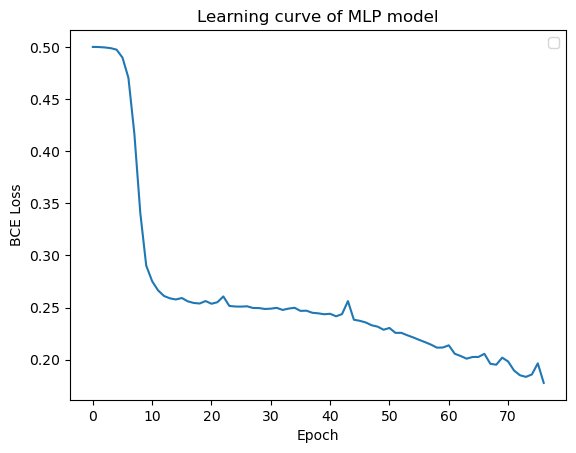

In [28]:
error_data_mlp = []
simulation_model = mlp_model.model.MLPModel(device='mps',num_tasks=5,num_context_dependent_hidden_units=128)

# model training
errors = calc_model_error(simulation_model,train_x,train_y)
c=1
while errors.mean() > 0.18:
    simulation_model.train(train_x,train_y,epochs=1)
    errors = calc_model_error(simulation_model,train_x,train_y)
    error_data_mlp += [errors.mean()]
    c+=1
print(model_idx, errors.mean(),c)

plt.plot(range(len(error_data_mlp)), error_data_mlp)

plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Learning curve of MLP model")
plt.legend()
plt.savefig("images/learning_curve_mlp.png")
plt.show()